In [21]:
from src.utils import *
from pathlib import Path
from nltk.probability import FreqDist
from src.preprocess import clean_tokens, date_to_astral, ASTRAL_DATES
from matplotlib import pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from functools import reduce

In [22]:
SELECTED_SIGN = list(ASTRAL_DATES.keys())
SELECTED_SIGN = [['Taurus', 'Sagittarius']]
DOCS_PATH = Path(f'data/lg/spacy.jsonl')

In [23]:
docs = read_jsonl(DOCS_PATH)

In [ ]:
df = pd.DataFrame(docs, columns=['path', 'birthDate', 'birthPlace', 'deathDate'])
df.head()

,path,birthDate,birthPlace,deathDate
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09


In [ ]:
df['astral_sign'] = df.birthDate.apply(date_to_astral)
df.head()

,path,birthDate,birthPlace,deathDate,abstract_tokens,page_tokens,astral_sign
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17,"[raju, daniel, june, september, known, stage, ...","[raju, daniel, june, september, known, stage, ...",Cancer
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None,"[gerd, audehm, born, august, schipkau, bezirk,...","[gerd, audehm, born, august, schipkau, bezirk,...",Leo
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None,"[saana, saarteinen, born, february, finnish, t...","[saana, saarteinen, born, february, finnish, t...",Aquarius
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None,"[melymel, mermelada, born, may, santo, domingo...","[melymel, mermelada, born, may, santo, domingo...",Taurus
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09,"[samuel, adler, december, june, leading, germa...","[samuel, adler, december, june, leading, germa...",Sagittarius


In [ ]:
df['astral_sign'].value_counts()

In [ ]:
df = df[~df['astral_sign'].isin(SELECTED_SIGN)]
df.reindex()

In [ ]:
cleaner = clean_tokens(keep_lemma=False, remove_month=False)
df[['abstract_tokens', 'page_tokens']] = [(cleaner(doc['abstract']), cleaner(doc['page'])) for doc in docs]
df.head()

c:\Users\pierr\.conda\envs\data-td\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,path,birthDate,birthPlace,deathDate,abstract_tokens,page_tokens
0,http://dbpedia.org/resource/Captain_Raju,1950-06-27,http://dbpedia.org/resource/Travancore-Cochin,2018-09-17,"[raju, daniel, june, september, known, stage, ...","[raju, daniel, june, september, known, stage, ..."
1,http://dbpedia.org/resource/Gerd_Audehm,1968-08-14,http://dbpedia.org/resource/Bezirk_Cottbus,None,"[gerd, audehm, born, august, schipkau, bezirk,...","[gerd, audehm, born, august, schipkau, bezirk,..."
2,http://dbpedia.org/resource/Saana_Saarteinen,1993-02-11,http://dbpedia.org/resource/Finland_Fed_Cup_team,None,"[saana, saarteinen, born, february, finnish, t...","[saana, saarteinen, born, february, finnish, t..."
3,http://dbpedia.org/resource/Melymel_(rapper),1988-05-06,http://dbpedia.org/resource/Santo_Domingo,None,"[melymel, mermelada, born, may, santo, domingo...","[melymel, mermelada, born, may, santo, domingo..."
4,http://dbpedia.org/resource/Samuel_Adler_(rabbi),1809-12-03,"http://dbpedia.org/resource/Worms,_Germany",1891-06-09,"[samuel, adler, december, june, leading, germa...","[samuel, adler, december, june, leading, germa..."


In [7]:
docs[0]['abstract']['sents']

[{'start': 0, 'end': 137},
 {'start': 138, 'end': 256},
 {'start': 257, 'end': 333},
 {'start': 334, 'end': 434},
 {'start': 435, 'end': 596}]

In [8]:
df['abstract_len'] = df['abstract_tokens'].apply(len)
df['page_len'] = df['page_tokens'].apply(len)
df['abstract_sent_len'] = [len(doc['abstract']['sents']) for doc in docs]
df['page_sent_len'] = [len(doc['page']['sents']) for doc in docs]

In [9]:
df[['abstract_len', 'page_len', 'abstract_sent_len', 'page_sent_len']].describe()

,abstract_len,page_len,abstract_sent_len,page_sent_len
count,6157.000000,6157.000000,6157.000000,6157.000000
mean,37.797304,313.600617,3.516323,26.681663
std,39.527626,507.205227,3.518299,42.265679
min,5.000000,7.000000,1.000000,1.000000
25%,15.000000,63.000000,1.000000,6.000000
50%,24.000000,159.000000,2.000000,14.000000
75%,44.000000,357.000000,4.000000,30.000000
max,415.000000,8479.000000,42.000000,821.000000


In [10]:
df.groupby('astral_sign')[['abstract_len', 'abstract_sent_len']].describe()

abstract_len                                                       \
                   count       mean        std  min   25%   50%    75%    max   
astral_sign                                                                     
Aquarius           542.0  35.416974  35.705919  6.0  15.0  22.0  41.00  247.0   
Aries              536.0  37.190299  35.637022  5.0  15.0  24.0  45.00  299.0   
Cancer             525.0  37.626667  37.344252  6.0  15.0  24.0  43.00  266.0   
Capricorn          546.0  36.551282  38.232967  5.0  14.0  22.0  42.00  311.0   
Gemini             536.0  36.272388  33.435843  6.0  15.0  25.0  44.00  241.0   
Leo                484.0  42.520661  47.690748  5.0  15.0  25.0  49.25  375.0   
Libra              486.0  41.820988  48.266430  6.0  15.0  24.0  48.75  415.0   
Pisces             511.0  37.512720  39.974739  6.0  15.0  23.0  41.00  345.0   
Sagittarius        456.0  38.337719  37.800633  6.0  15.0  25.0  51.00  308.0   
Scorpio            530.0  35.311321  34.701907  5.0  15.0  23.0  42.00  290.0   
Taurus             508.0  35.862205  39.392887  6.0  14.0  22.0  41.00  302.0   
Virgo              497.0  40.132797  44.318205  6.0  15.0  26.0  47.00  412.0   

            abstract_sent_len                                                
                        count      mean       std  min  25%  50%  75%   max  
astral_sign                                                                  
Aquarius                542.0  3.234317  3.145646  1.0  1.0  2.0  4.0  22.0  
Aries                   536.0  3.430970  3.197384  1.0  1.0  2.0  4.0  26.0  
Cancer                  525.0  3.457143  3.300557  1.0  1.0  2.0  4.0  21.0  
Capricorn               546.0  3.435897  3.412405  1.0  1.0  2.0  4.0  25.0  
Gemini                  536.0  3.421642  3.116045  1.0  1.0  2.0  4.0  21.0  
Leo                     484.0  3.931818  3.966931  1.0  1.0  3.0  5.0  29.0  
Libra                   486.0  3.839506  4.230835  1.0  1.0  2.0  5.0  33.0  
Pisces                  511.0  3.504892  3.633649  1.0  1.0  2.0  4.0  29.0  
Sagittarius             456.0  3.589912  3.349369  1.0  2.0  2.0  5.0  26.0  
Scorpio                 530.0  3.258491  3.207266  1.0  1.0  2.0  4.0  26.0  
Taurus                  508.0  3.446850  3.610079  1.0  1.0  2.0  4.0  28.0  
Virgo                   497.0  3.738431  3.941098  1.0  2.0  3.0  4.0  42.0

In [11]:
df.groupby('astral_sign')[['page_len', 'page_sent_len']].describe()

page_len                                                      \
               count        mean         std   min    25%    50%     75%   
astral_sign                                                                
Aquarius       542.0  293.988930  474.672522  12.0  55.00  156.5  356.75   
Aries          536.0  327.755597  573.246946  10.0  66.00  161.0  377.00   
Cancer         525.0  330.276190  552.514124  10.0  63.00  168.0  355.00   
Capricorn      546.0  280.895604  514.936122   7.0  55.25  132.5  297.50   
Gemini         536.0  311.526119  484.194600   9.0  62.00  161.5  359.50   
Leo            484.0  380.778926  647.917261   9.0  76.00  178.5  411.25   
Libra          486.0  317.781893  487.887876  10.0  66.00  162.0  355.00   
Pisces         511.0  308.825832  427.264210   9.0  69.00  168.0  366.50   
Sagittarius    456.0  311.763158  435.363868  10.0  57.75  162.0  383.50   
Scorpio        530.0  293.288679  413.574685  10.0  67.00  162.5  351.50   
Taurus         508.0  285.375984  509.085964   9.0  57.75  146.0  312.75   
Virgo          497.0  327.869215  517.161718  12.0  73.00  186.0  401.00   

                    page_sent_len                                              \
                max         count       mean        std  min  25%   50%   75%   
astral_sign                                                                     
Aquarius     6472.0         542.0  24.603321  36.275892  1.0  5.0  14.0  30.0   
Aries        8479.0         536.0  28.837687  54.396655  2.0  6.0  14.5  32.0   
Cancer       5324.0         525.0  28.466667  48.611143  1.0  6.0  14.0  29.0   
Capricorn    5589.0         546.0  23.525641  40.276069  1.0  5.0  12.0  24.0   
Gemini       5554.0         536.0  26.791045  42.718697  1.0  6.0  14.0  30.0   
Leo          5773.0         484.0  31.892562  50.693052  1.0  7.0  15.0  35.0   
Libra        4940.0         486.0  26.954733  40.777925  1.0  6.0  14.0  30.0   
Pisces       4208.0         511.0  25.888454  36.155509  1.0  6.0  15.0  30.0   
Sagittarius  4235.0         456.0  27.839912  38.653016  1.0  6.0  14.0  33.0   
Scorpio      3813.0         530.0  25.043396  33.927533  1.0  6.0  15.0  29.0   
Taurus       6286.0         508.0  24.464567  42.267728  1.0  5.0  13.0  27.0   
Virgo        6344.0         497.0  26.511066  36.602821  1.0  6.0  15.0  33.0   

                    
               max  
astral_sign         
Aquarius     404.0  
Aries        821.0  
Cancer       565.0  
Capricorn    478.0  
Gemini       542.0  
Leo          442.0  
Libra        436.0  
Pisces       388.0  
Sagittarius  309.0  
Scorpio      317.0  
Taurus       575.0  
Virgo        419.0

abstract_len    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

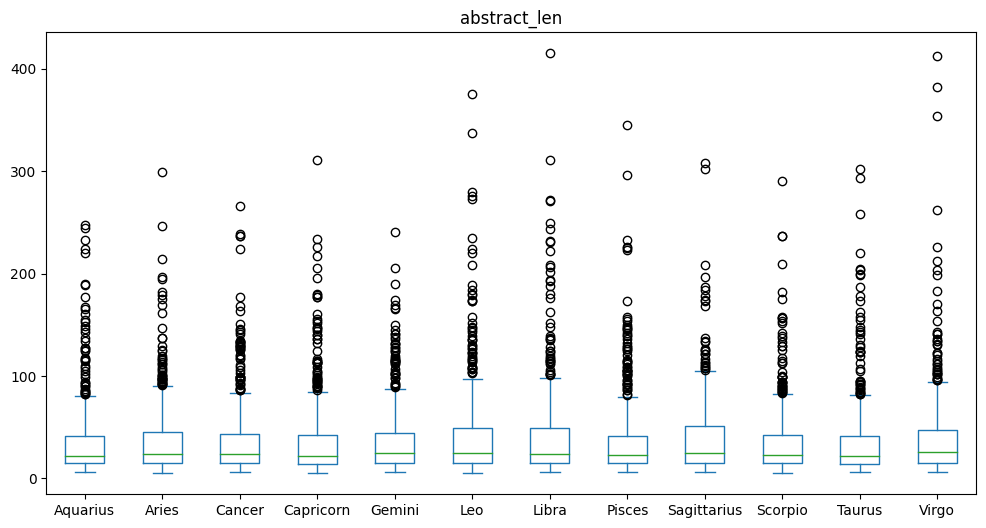

In [12]:
df[['astral_sign', 'abstract_len']].plot.box('astral_sign', figsize=(12,6))

page_len    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

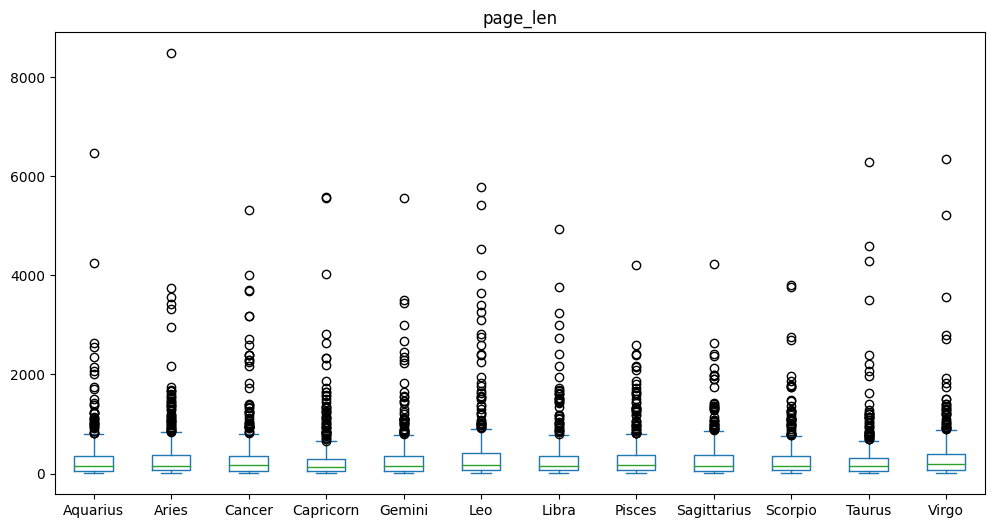

In [13]:
df[['astral_sign', 'page_len']].plot.box('astral_sign', figsize=(12,6))

abstract_sent_len    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

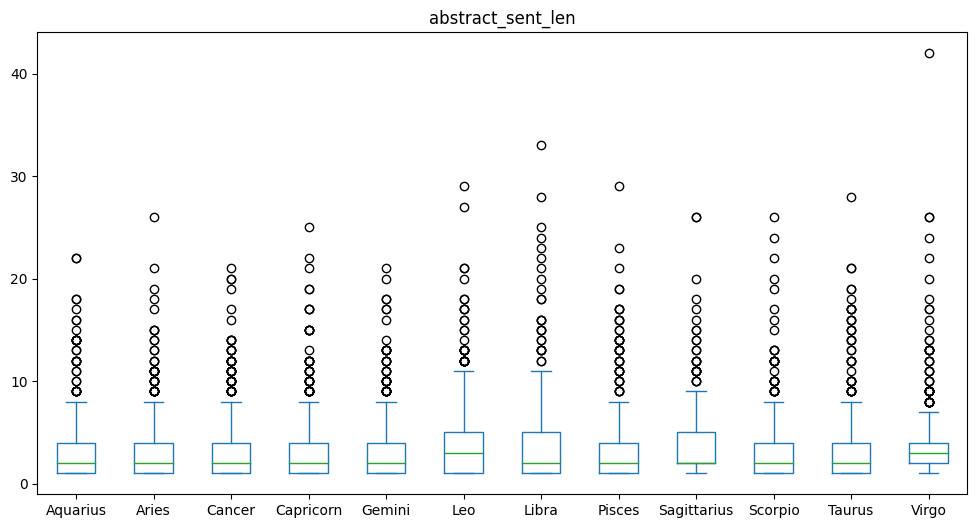

In [14]:
df[['astral_sign', 'abstract_sent_len']].plot.box('astral_sign', figsize=(12,6))

page_sent_len    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

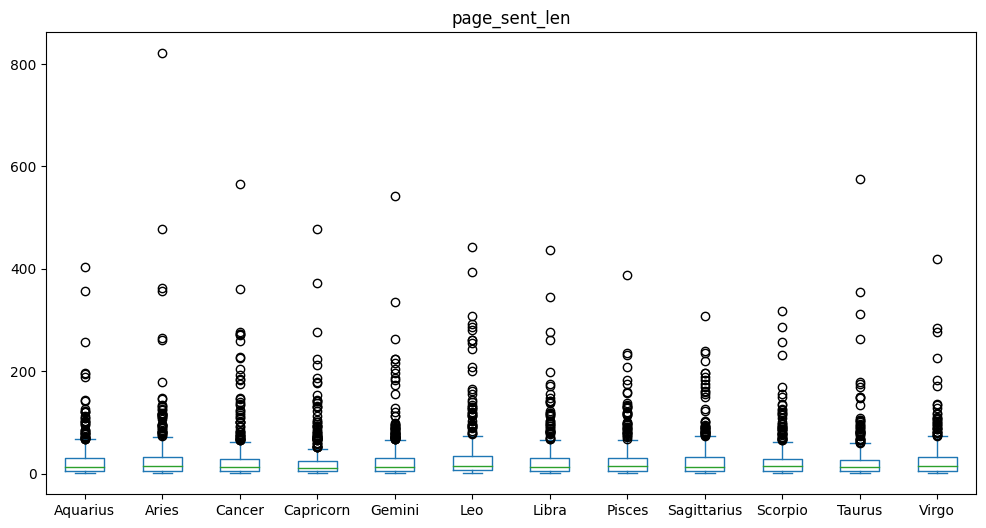

In [15]:
df[['astral_sign', 'page_sent_len']].plot.box('astral_sign', figsize=(12,6))

In [16]:
def compute_freqs(df, target):
    freqs = {}
    for sign in df['astral_sign'].sort_values().unique():
        freqs[sign] = FreqDist(reduce(lambda a, b: a + b, df[df['astral_sign'] == sign][target], []))
    return freqs

def make_wordclouds(freqs):
    wc = WordCloud(background_color="white", max_words=50, contour_width=3, contour_color='steelblue')
    fig = plt.figure(figsize=(12,9))
    tmp = {}
    for i, freq in enumerate(freqs.items()):
        sign, freq = freq
        tmp[sign] = wc.generate_from_frequencies(freq)
        fig.add_subplot(4,3,i+1)
        plt.imshow(tmp[sign])
        plt.title(sign)

In [17]:
abstract_freqs = compute_freqs(df, 'abstract_tokens')

In [18]:
page_freqs = compute_freqs(df, 'page_tokens')

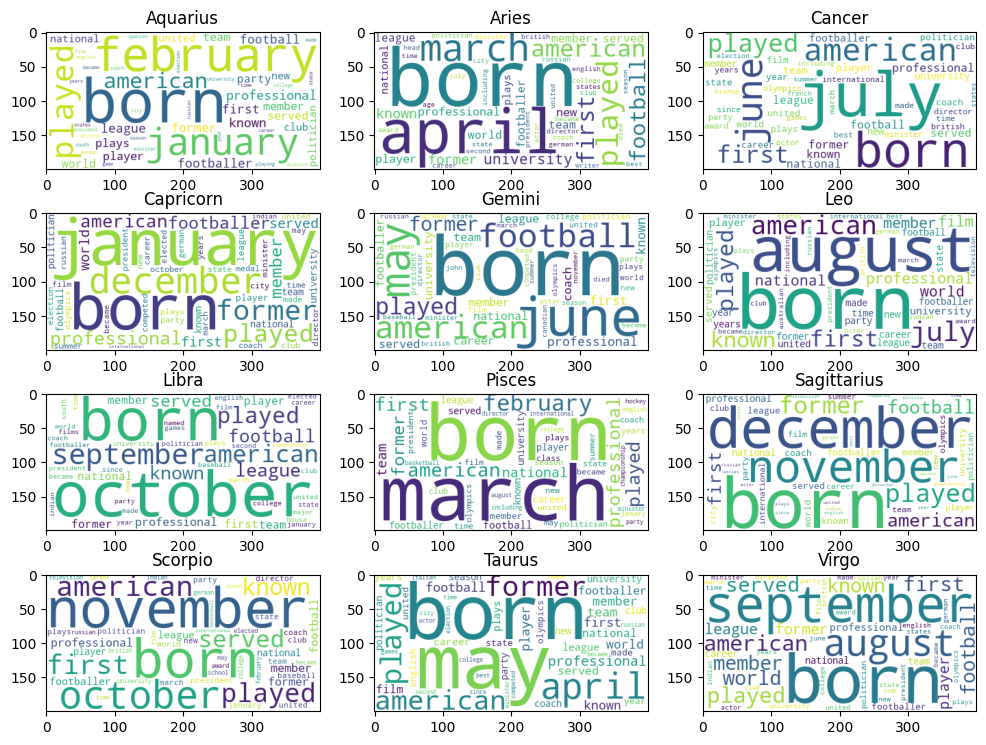

In [19]:
make_wordclouds(abstract_freqs)

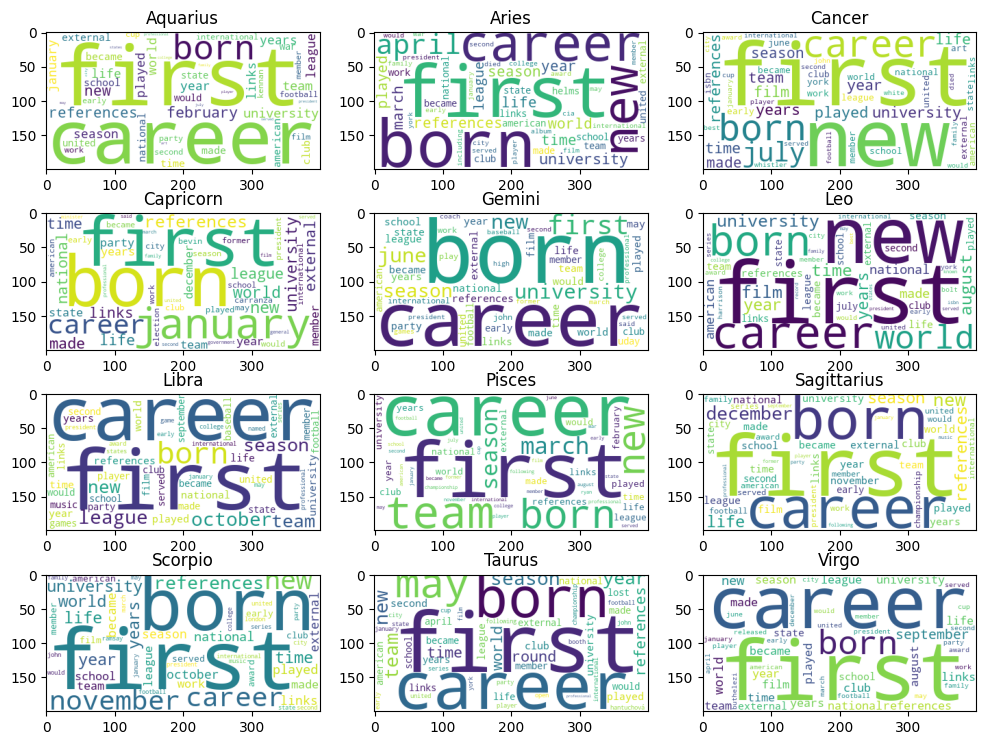

In [20]:
make_wordclouds(page_freqs)

words = reduce(lambda a, b: a | set([t.lower() for t in b]), df['tokens'], set())

print(len(vectorizer.vocabulary_), len(features), len(words))

def check(x):
    word = 'apple'
    for t in x:
        if t.lower() == word:
            print(t, x)
_ = df['tokens'].apply(check)

In [12]:
vectorizer = CountVectorizer(lowercase=False, token_pattern=r'([^\s]+)')
X = vectorizer.fit_transform(df['page_tokens'].apply(lambda x: ' '.join(x)))
features = vectorizer.get_feature_names_out()
freqs = pd.DataFrame(zip(features, np.asarray((X != 0).astype(int).mean(axis=0)).flatten()), columns=['word', 'freq'])
freqs.sort_values('freq', ascending=False)

,word,freq
116350,reference,0.941855
95675,bear,0.874289
109181,link,0.701640
103082,external,0.696443
97225,career,0.490823
...,...,...
29513,Gade,0.000162
29514,Gadegaon,0.000162
71097,Rosport,0.000162
71096,Rospil,0.000162


In [11]:
def terms_to_docs(x):
    return np.asarray((x != 0).astype(int).mean(axis=0)).flatten()

vectorizer = CountVectorizer(lowercase=False, token_pattern=r'([^\s]+)')
vectorizer = vectorizer.fit(df['abstract_tokens'].apply(lambda x: ' '.join(x)))
features = vectorizer.get_feature_names_out()

X = vectorizer.transform(df['abstract_tokens'].apply(lambda x: ' '.join(x)))
X = terms_to_docs(X)
freqs = pd.DataFrame(
    zip(features, X), 
    columns=['word', 'all_freq']    
)

for asign in df['astral_sign'].unique():
    X = vectorizer.transform(df[df['astral_sign'] == asign]['abstract_tokens'].apply(lambda x: ' '.join(x)))
    X = terms_to_docs(X)
    freqs[f'{asign}_freq'] = X

freqs.describe()

,all_freq,Cancer_freq,Leo_freq,Aquarius_freq,Taurus_freq,Sagittarius_freq,Gemini_freq,Libra_freq,Capricorn_freq,Virgo_freq,Scorpio_freq,Aries_freq,Pisces_freq
count,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000,36207.000000
mean,0.000821,0.000818,0.000920,0.000778,0.000782,0.000841,0.000792,0.000884,0.000788,0.000872,0.000770,0.000818,0.000815
std,0.005478,0.005681,0.005778,0.005537,0.005719,0.005603,0.005523,0.005766,0.005584,0.005708,0.005337,0.005429,0.005700
min,0.000162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.665584,0.643810,0.644628,0.664207,0.692913,0.671053,0.690299,0.641975,0.683150,0.661972,0.654717,0.651119,0.684932


In [ ]:
freqs[~freqs['word'].isin(MONTHS)].describe()

In [ ]:
for col in freqs.columns:
    print(col, freqs[~freqs['word'].isin(MONTHS)].sort_values(col, ascending=False)['word'][:5].values)

In [ ]:
freqs[~freqs['word'].isin(MONTHS)].plot.box()

In [ ]:
TARGET = 'bear'
vectorizer = CountVectorizer(lowercase=False, token_pattern=r'([^\s]+)')
X = vectorizer.fit_transform(df['tokens'].apply(lambda x: ' '.join(x)))
features = vectorizer.get_feature_names_out()
tindex = list(features).index(TARGET)
df[(X[:, tindex] == 0).toarray().flatten()]

# freqs = pd.DataFrame(zip(features, np.asarray((X != 0).astype(int).mean(axis=0)).flatten()), columns=['word', 'freq'])
# freqs.sort_values('freq', ascending=False)